<a href="https://colab.research.google.com/github/DaryaTereshchenko/HateSpeechDetection/blob/main/HateBert_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentence_transformers
!pip install transformers

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import tensorflow as tf
from sentence_transformers import SentenceTransformer
from transformers import RobertaTokenizer

In [5]:
from transformers import RobertaTokenizer, RobertaConfig, TFRobertaModel

In [ ]:
ethos_hate = pd.read_csv("ethos_hate.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_hate["label"] = 1

ethos_neutral = pd.read_csv("ethos_neutral.csv", sep=",", encoding="unicode_escape").drop(columns="label")
ethos_neutral["label"] = 0

train_n = ethos_neutral.sample(frac=0.9, random_state=0)
test_n = ethos_neutral.drop(train_n.index)

train_hate = ethos_hate.sample(frac=0.9, random_state=0)
test_hate = ethos_hate.drop(train_hate.index)


train = pd.concat([train_n, train_hate]).sample(frac=1, random_state=300).reset_index(drop=True)
test = pd.concat([test_n, test_hate]).sample(frac=1, random_state=300).reset_index(drop=True)

print(train.text[0])


What episode number was this?


In [ ]:
print(test.label)

0     0
1     1
2     0
3     1
4     0
     ..
95    0
96    1
97    0
98    1
99    1
Name: label, Length: 100, dtype: int64


In [ ]:
train.text

0                          What episode number was this?
1      Why don't you go beck your god to murder you? ...
2      I don't like jew soap, but if we are to get ri...
3      By calling period, a natural procedure, as an ...
4         MASS BLACK WORLDWIDE GENOCIDE IS OUR ONLY HOPE
                             ...                        
893    Is this world filled by those stupid female bi...
894                   What type of question it is???????
895                    Die fucking arab dude sand niggas
896               Japanese culture is ancient and unique
897    People who say "YAAAASSSS QUEEN" should be ste...
Name: text, Length: 898, dtype: object

In [ ]:
print("Longest sentence?")
print(max(len(x) for x in train.text.values))
print("Average length?")
print(sum(len(x) for x in train.text.values) / len(train.text.values))


Longest sentence?
3009
Average length?
111.76948775055679


In [ ]:
def clean_text(line):
  processed_line = line.lower()
  words = [word for word in word_tokenize(processed_line)]
  processed_line = [word for word in words if word not in set(string.punctuation)]
  text = " ".join(processed_line)
  return text

In [ ]:
# Sentences for embeddings
train_sentence_list = list(map(clean_text, train.text.values))
test_sentence_list = list(map(clean_text, test.text.values))

In [ ]:
train_sentence_list

In [ ]:
from transformers import AutoTokenizer, TFAutoModel

In [ ]:
MODEL_NAME = 'GroNLP/hateBERT'
MAX_LEN = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
def roberta_encode(texts, tokenizer):
    ct = len(texts)
    input_ids = np.ones((ct, MAX_LEN), dtype='int32')
    attention_mask = np.zeros((ct, MAX_LEN), dtype='int32')
    token_type_ids = np.zeros((ct, MAX_LEN), dtype='int32') # Not used in text classification

    for k, text in enumerate(texts):
        # Tokenize
        tok_text = tokenizer.tokenize(text)
        
        # Truncate and convert tokens to numerical IDs
        enc_text = tokenizer.convert_tokens_to_ids(tok_text[:(MAX_LEN-2)])
        
        input_length = len(enc_text) + 2
        input_length = input_length if input_length < MAX_LEN else MAX_LEN
        
        # Add tokens [CLS] and [SEP] at the beginning and the end
        input_ids[k,:input_length] = np.asarray([0] + enc_text + [2], dtype='int32')
        
        # Set to 1s in the attention input
        attention_mask[k,:input_length] = 1

    return {
        'input_word_ids': input_ids,
        'input_mask': attention_mask,
        'input_type_ids': token_type_ids
    }

In [ ]:
X_train = roberta_encode(train_sentence_list, tokenizer)
X_test = roberta_encode(test_sentence_list, tokenizer)

y_train = np.asarray(train.label, dtype='int32').reshape(-1,1)
y_test = np.asarray(test.label, dtype='int32').reshape(-1,1)

Token indices sequence length is longer than the specified maximum sequence length for this model (776 > 512). Running this sequence through the model will result in indexing errors


In [ ]:
def build_model():
  input_word_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.Input(shape=(MAX_LEN,), dtype=tf.int32, name='input_type_ids')

  # Import RoBERTa model from HuggingFace
  roberta_model = TFAutoModel.from_pretrained("GroNLP/hateBERT", from_pt=True)
  x = roberta_model(input_word_ids, attention_mask=input_mask, token_type_ids=input_type_ids)

  # Huggingface transformers have multiple outputs, embeddings are the first one,
  # so let's slice out the first position
  x = x[0]

  x = tf.keras.layers.Dropout(0.1)(x)
  x = tf.keras.layers.Conv1D(64, 5, activation='relu')(x)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(16, activation='relu')(x)
  x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

  model = tf.keras.Model(inputs=[input_word_ids, input_mask, input_type_ids], outputs=x)
  model.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
      loss= tf.keras.losses.binary_crossentropy,
      metrics=['accuracy'])

  return model

In [ ]:
model = build_model()
model.summary()
tf.keras.utils.plot_model(model)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predict

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_10 (TFBertModel)  TFBaseModelOutputWi  109482240  ['input_word_ids[0][0]',         
                                thPoolingAndCrossAt               'input_mask[0][0]',       

In [ ]:
print('Training...')
history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=16,
                    verbose=1,
                    validation_data=(X_test, y_test))

Training...
Epoch 1/10


57/57 [==============================] - 67s 857ms/step - loss: 0.6898 - accuracy: 0.5557 - val_loss: 0.6518 - val_accuracy: 0.5900
Epoch 2/10
57/57 [==============================] - 44s 773ms/step - loss: 0.6089 - accuracy: 0.6659 - val_loss: 0.5512 - val_accuracy: 0.7600
Epoch 3/10
57/57 [==============================] - 44s 776ms/step - loss: 0.5098 - accuracy: 0.7517 - val_loss: 0.5039 - val_accuracy: 0.8100
Epoch 4/10
57/57 [==============================] - 44s 769ms/step - loss: 0.3326 - accuracy: 0.8597 - val_loss: 0.5734 - val_accuracy: 0.8000
Epoch 5/10
57/57 [==============================] - 44s 774ms/step - loss: 0.2286 - accuracy: 0.9098 - val_loss: 0.7312 - val_accuracy: 0.7000
Epoch 6/10
57/57 [==============================] - 44s 771ms/step - loss: 0.1475 - accuracy: 0.9543 - val_loss: 0.6331 - val_accuracy: 0.7600
Epoch 7/10
57/57 [==============================] - 44s 769ms/step - loss: 0.0969 - accuracy: 0.9666 - val_loss: 0.6990 - val_accuracy: 0.7700
Epoch 8/10

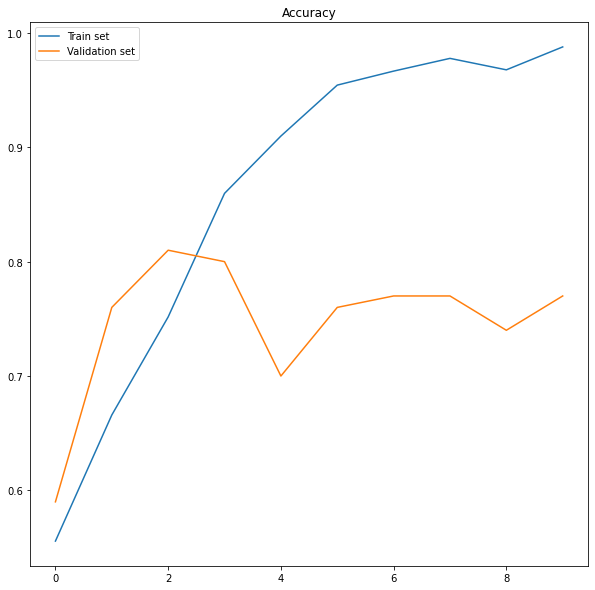

In [ ]:
# This plot will look much better if we train models with more epochs, but anyway here is
plt.figure(figsize=(10, 10))
plt.title('Accuracy')

xaxis = np.arange(len(history.history['accuracy']))
plt.plot(xaxis, history.history['accuracy'], label='Train set')
plt.plot(xaxis, history.history['val_accuracy'], label='Validation set')
plt.legend()


In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Accuracy: 77.00%


In [ ]:
y_pred = [int(np.round(i,0)) for i in model.predict(X_test)]

4/4 [==============================] - 4s 216ms/step


In [ ]:
y_pred

In [ ]:
y_test

In [ ]:
from sklearn.metrics import confusion_matrix
con_mat_df = confusion_matrix(y_test, y_pred)
con_mat_df = con_mat_df.astype('float') / con_mat_df.sum(axis=1)[:, np.newaxis]

[[0.75438596 0.24561404]
 [0.20930233 0.79069767]]


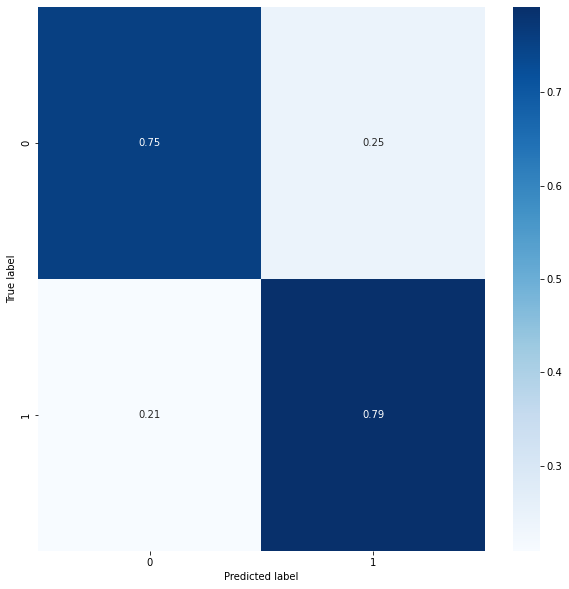

In [ ]:
import seaborn as sns
figure = plt.figure(figsize=(10, 10))
sns.heatmap(con_mat_df, cmap=plt.cm.Blues, annot=True)
plt.ylabel('True label')
plt.xlabel('Predicted label')
print(con_mat_df)